*Estimado profesor Fernando*

**Proyecto de Data Science III - Comisión 61195**


# *Abstracto con Motivación y Audiencia*

Este proyecto se enfoca en analizar reseñas de usuarios de Netflix en Google Play Store utilizando técnicas de procesamiento de lenguaje natural (NLP). Las reseñas en línea influyen significativamente en la percepción de la calidad del servicio y las decisiones de suscripción. Por ello, es crucial entender cómo los usuarios evalúan su experiencia con la plataforma. Este análisis está dirigido a equipos de gestión de producto, especialistas en experiencia del usuario (UX), y profesionales de marketing, quienes pueden aprovechar estos insights para mejorar el servicio y optimizar la satisfacción del cliente.

# *Contexto Comercial y Analítico*
Netflix es una de las plataformas de streaming líderes a nivel global, con millones de usuarios activos en todo el mundo. Las reseñas en Google Play Store reflejan tanto las fortalezas como las áreas de mejora percibidas por los usuarios. Estas opiniones son clave para mantener una ventaja competitiva en un mercado con creciente competencia.

Desde una perspectiva comercial, analizar las reseñas puede proporcionar insights valiosos sobre aspectos que impulsan la retención de usuarios y la adquisición de nuevos suscriptores. Utilizar técnicas de NLP para extraer información del texto de las reseñas permite identificar patrones de satisfacción o insatisfacción, temas recurrentes, y los factores críticos que impactan la percepción del servicio.

*Las preguntas que guiarán este análisis son:*

**¿Qué proporción de las reseñas refleja experiencias positivas, negativas o neutrales?**
Hipótesis: La mayoría de las reseñas son positivas, dado que Netflix es un líder en el mercado de streaming.

**¿Cuáles son los temas recurrentes en las reseñas negativas?**
Hipótesis: Los temas principales están relacionados con problemas técnicos, contenido insuficiente en ciertas regiones, o precios elevados.

**¿Existen tendencias temporales en el sentimiento de las reseñas?**
Hipótesis: Las reseñas negativas tienden a aumentar después de actualizaciones importantes o cambios en las tarifas.

#Objetivo
El objetivo de este proyecto es desarrollar un modelo de análisis de sentimientos que clasifique automáticamente las reseñas de usuarios de Netflix como positivas, negativas o neutrales. Además, se busca identificar temas clave en las reseñas negativas para proponer mejoras en la experiencia de usuario y la oferta de servicios. Al aplicar técnicas de NLP y un modelo de clasificación, este análisis proporcionará información estratégica que permitirá a los gestores de producto tomar decisiones informadas para fortalecer la percepción de la marca y la satisfacción del cliente



In [2]:

import requests
import zipfile
import os

# URL directa del archivo ZIP en GitHub
url = "https://github.com/DNDataSphere/DSIII_61195_Coderhouse/raw/main/netflix_reviews.zip"

# Nombre del archivo ZIP local
zip_path = "netflix_reviews.zip"

# Descargar el archivo ZIP
response = requests.get(url)
if response.status_code == 200:
    with open(zip_path, "wb") as file:
        file.write(response.content)
    print(f"Archivo descargado correctamente: {zip_path}")
else:
    print(f"Error al descargar el archivo: {response.status_code}")

# Verificar si el archivo ZIP existe antes de descomprimir
if os.path.exists(zip_path):
    # Descomprimir el archivo ZIP
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall("contenido_zip")  # Carpeta donde se descomprime el contenido
    print("Contenido extraído:", os.listdir("contenido_zip"))
else:
    print(f"No se encontró el archivo {zip_path} para descomprimir.")



Archivo descargado correctamente: netflix_reviews.zip
Contenido extraído: ['netflix_reviews.csv']


*Lectura del conjunto de datos*

In [3]:

import pandas as pd
import matplotlib.pyplot as plt

# Ruta del archivo CSV descomprimido
file_path = "contenido_zip/netflix_reviews.csv"

# Cargar el dataset usando pandas
df = pd.read_csv(file_path, delimiter=",", encoding="ISO-8859-1")

# Mostrar las primeras filas del dataset
print("Primeras filas del dataset:")
print(df.head())

# Información general del dataset
print("\nInformación general del dataset:")
df.info()

# Descripción estadística de las variables numéricas
print("\nDescripción estadística de las variables numéricas:")
print(df.describe())

# Número de columnas y filas
print(f"\nEl dataset tiene {df.shape[0]} filas y {df.shape[1]} columnas.")


Primeras filas del dataset:
                               reviewId  \
0  9a28601b-8d2a-49a5-b48e-b33e12bffba8   
1  8b4a6269-598c-4e6c-8c34-e3d390dac58c   
2  45ba990c-83ac-4ab2-adad-9f6ff7de6a6a   
3  966d2695-b345-4012-b1b2-3cd02f504aa3   
4  988f4e66-df5c-40ec-bb90-a862dbd682a9   

                                       userName  \
0                                 venkat rayudu   
1                                Marion Balondo   
2                                   SUBRAT GOLU   
3                                    john Jones   
4  Sunny SOHAIL âSunny Boy Sun Shineâ Ahmed   

                                             content  score  thumbsUpCount  \
0  Chillarix 0 star is very low for this company....      1              0   
1                                               Nice      5              0   
2                                     Very nice ð      3              0   
3  kicked me out of my games , from netflix and w...      1              2   
4               

**El dataset contiene 122,304 observaciones y las siguientes columnas principales:**

reviewId: Identificador único para cada reseña.

userName: Nombre del usuario que escribió la reseña.

content: El texto de la reseña (columna clave para el análisis de NLP).

score: Calificación dada por el usuario (de 1 a 5).

thumbsUpCount: Cantidad de "me gusta" recibidos en la reseña.

reviewCreatedVersion y appVersion: Versiones de la aplicación relacionadas con la reseña.

at: Fecha y hora de la reseña.


**Insights inciales:**

La columna content es la que nos va a ayudar a generar el **Corpus**, pero hay valores nulos que debemos manejar.

La columna score sera la que utilizaremos como una etiqueta para clasificar las reseñas en positivas, negativas o neutrales.

Algunas columnas como reviewCreatedVersion y appVersion tienen valores nulos y pueden no ser relevantes para el análisis.

A continuación, realizaremos una limpieza inicial de los datos y exploraremos su estructura básica. Eliminaremos los textos vacíos o nulos de nuestro dataset y reiniciaremos el índice para asegurar un flujo ordenado de datos.

In [4]:
import re
import pandas as pd

# Definir la función para preprocesar texto
def preprocess_text(text):
    if isinstance(text, float):
        return ""
    text = text.lower()  # Convertir a minúsculas
    text = re.sub(r'[^\w\s]', '', text)  # Eliminar puntuación
    text = re.sub(r'\d+', '', text)  # Eliminar números
    text = text.strip()  # Eliminar espacios al inicio y al final
    return text

# Limpiar valores nulos iniciales
df_cleaned = df.dropna(subset=['content']).reset_index(drop=True)

# Aplicar preprocesamiento de texto a una nueva columna
df_cleaned['processed_content'] = df_cleaned['content'].apply(preprocess_text)

# Revisar valores nulos en el DataFrame
print("Total de valores nulos antes de llenar:", df_cleaned.isnull().sum().sum())

# Llenar valores nulos restantes con cadenas vacías
df_cleaned.fillna('', inplace=True)

# Convertir la columna 'at' a formato datetime
df_cleaned['at'] = pd.to_datetime(df_cleaned['at'], errors='coerce')

# Crear una nueva columna 'content_c' aplicando nuevamente el preprocesamiento
df_cleaned['content_c'] = df_cleaned['content'].apply(preprocess_text)

# Seleccionar columnas relevantes para el análisis
df_cleaned = df_cleaned[['content_c', 'score', 'reviewId', 'at']]

# Distribución de las calificaciones
score_distribution = df_cleaned['score'].value_counts()

# Mostrar resultados clave
print("Cantidad de datos después de limpieza:", df_cleaned.shape)
print("\nDistribución de las calificaciones:")
print(score_distribution)

print("\nPrimeras filas del dataset limpio:")
print(df_cleaned.head())

print("\nTotal de valores nulos después de llenar:", df_cleaned.isnull().sum().sum())



Total de valores nulos antes de llenar: 37900
Cantidad de datos después de limpieza: (122300, 4)

Distribución de las calificaciones:
score
1    48020
5    35965
4    14463
3    12522
2    11330
Name: count, dtype: int64

Primeras filas del dataset limpio:
                                           content_c  score  \
0  chillarix  star is very low for this company i...      1   
1                                               nice      5   
2                                        very nice ð      3   
3  kicked me out of my games  from netflix and wo...      1   
4                                                how      3   

                               reviewId                  at  
0  9a28601b-8d2a-49a5-b48e-b33e12bffba8 2024-12-21 15:47:15  
1  8b4a6269-598c-4e6c-8c34-e3d390dac58c 2024-12-21 15:32:10  
2  45ba990c-83ac-4ab2-adad-9f6ff7de6a6a 2024-12-21 15:23:47  
3  966d2695-b345-4012-b1b2-3cd02f504aa3 2024-12-21 15:20:29  
4  988f4e66-df5c-40ec-bb90-a862dbd682a9 2024-12-21 15:

In [5]:
print("Fecha de la reseña más antigua:", df_cleaned['at'].min())
print("Fecha de la reseña más reciente:", df_cleaned['at'].max())


Fecha de la reseña más antigua: 2018-09-12 07:22:12
Fecha de la reseña más reciente: 2024-12-21 15:47:15



**Resumen de la Limpieza de Datos**

Nuestro dataset inicial de reseñas de Netflix presento un desafío significativo: 37,900 valores nulos en la columna de contenido. Tras un proceso de limpieza y preprocesamiento, logramos recuperar una base de datos sólida con 122,300 reseñas válidas, distribuidos en cuatro columnas clave: contenido de la reseña, calificación, ID de la reseña y fecha de publicación.

Análisis de las Calificaciones
El análisis de la distribución de las calificaciones nos revela un patrón interesante:

1 estrella domina con 48,020 reseñas, lo que sugiere un porcentaje significativo de insatisfacción entre los usuarios.

Sin embargo, también hay un número considerable de calificaciones de 5 estrellas con 35,965 reseñas, mostrando una polarización clara en la percepción de los usuarios.

Las calificaciones intermedias (4, 3 y 2 estrellas) tienen un menor peso, lo que indica que las opiniones tienden a ser muy positivas o muy negativas.

Además, el rango temporal de nuestras reseñas abarca desde 2018 hasta 2024, brindándonos una oportunidad única para estudiar la evolución de la percepción de los usuarios a lo largo del tiempo y en relación con eventos clave de la plataforma

# **EDA**

Vamos un poco con analisis exploratorio

<ipython-input-6-65754497ac7d>:46: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




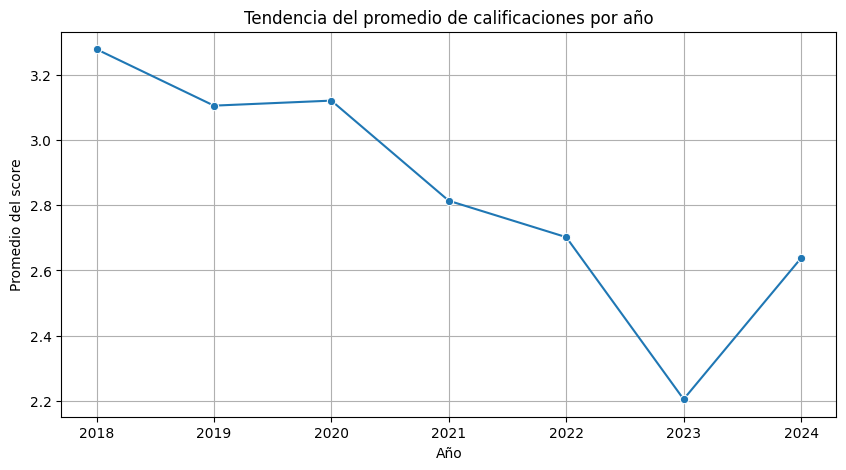

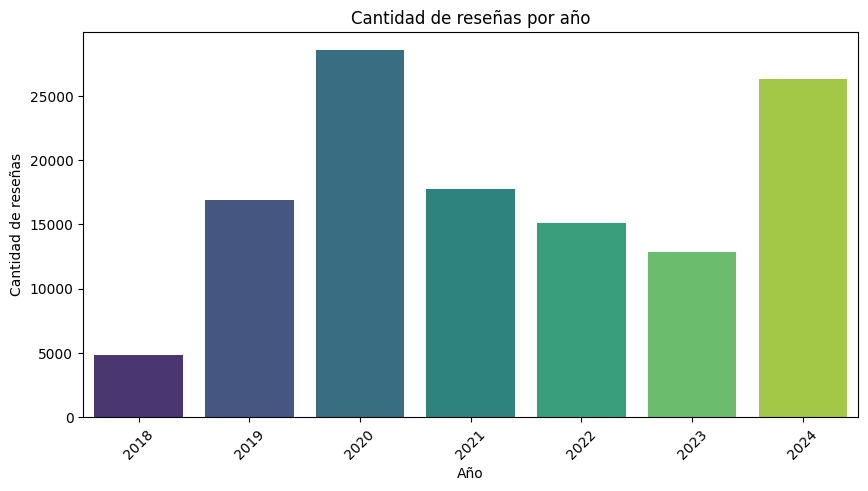

In [6]:
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns

# Convertir At en un columna
df['at'] = pd.to_datetime(df['at'], errors='coerce')

# Crear una nueva columna para el año
df['year'] = df['at'].dt.year
# Agrupación por año y score para contar reseñas
score_year = df.groupby(['year', 'score']).size().reset_index(name='count')

# Gráfico de barras apiladas: score por año
# Datos para gráfico apilado
pivot_score_year = score_year.pivot(index='year', columns='score', values='count').fillna(0)

# Crear trazos para cada score
data = []
for score in pivot_score_year.columns:
    trace = go.Bar(name=str(score), x=pivot_score_year.index, y=pivot_score_year[score])
    data.append(trace)

# Crear la figura
fig = go.Figure(data=data)

# Ajustar el diseño
fig.update_layout(barmode='stack', title='Distribución de calificaciones por año', xaxis_title='Año', yaxis_title='Cantidad de reseñas', legend_title='Score')

# Mostrar el gráfico
fig.show()

# Tendencia del promedio de scores por año
avg_score_year = df.groupby('year')['score'].mean().reset_index()
plt.figure(figsize=(10, 5))
sns.lineplot(data=avg_score_year, x='year', y='score', marker='o')
plt.title("Tendencia del promedio de calificaciones por año")
plt.xlabel("Año")
plt.ylabel("Promedio del score")
plt.grid(True)


# Análisis del volumen de reseñas por año
reviews_per_year = df['year'].value_counts().sort_index()
plt.figure(figsize=(10, 5))
sns.barplot(x=reviews_per_year.index, y=reviews_per_year.values, palette='viridis')
plt.title("Cantidad de reseñas por año")
plt.xlabel("Año")
plt.ylabel("Cantidad de reseñas")
plt.xticks(rotation=45)
plt.show()


*Observaciones posterioires al EDA:*  


Polarización: Se observa una clara polarización en las calificaciones, con una alta concentración en las puntuaciones extremas (1 y 5 estrellas). Esto sugiere que los usuarios tienden a tener opiniones muy marcadas sobre el contenido de Netflix.

Dominancia de calificaciones bajas: A lo largo de los años, las calificaciones de 1 estrella han sido consistentemente altas, lo que indica un nivel significativo de insatisfacción entre los usuarios... (Esto se apoya tambien con lo que observamos en el segundo grafico, en el promedio de las calificaciones desde 2018 hasta 2023. Indicandonos una disminución general en la satisfacción de los usuarios con el contenido y los servicios ofrecidos por Netflix durante este período.) lo que podria rempresentar un *sesgo mas adelante para el modelo*

Impacto de la pandemia (2020): El año 2020 presenta un pico en las calificaciones, tanto positivas como negativas. Esto podría indicar un aumento en el consumo de Netflix debido a las restricciones por la pandemia, lo que a su vez generó una mayor diversidad de opiniones.

Tendencia general: A pesar de las fluctuaciones anuales, la tendencia general muestra una ligera disminución en las calificaciones más altas (4 y 5 estrellas) a partir de 2020.

Por otro lado, se observa un pico pronunciado en la cantidad de reseñas durante el año 2020. Este aumento coincide con el inicio de la pandemia y sugiere que la mayor cantidad de tiempo libre disponible llevó a un incremento en el consumo de contenido de Netflix por ende, en la generación de opiniones, no podemos dejar pasar la recuperación en la cantidad de reseñas en 2024, lo que indica que el interés de los usuarios por compartir sus opiniones sobre Netflix se ha mantenido o incluso aumentado después de la pandemia.

Sin embargo, es necesario realizar un análisis más profundo para comprender las razones detrás de las variaciones en la cantidad de reseñas y su relación con la satisfacción de los usuarios.

# Inciemos con **NPL preprocesamiento**


In [7]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import plotly.express as px
import plotly.graph_objects as go

# Descargar stopwords y WordNet
nltk.download('stopwords')
nltk.download('wordnet')

# Inicializamos el lematizador y las stopwords
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

# Definir la función de preprocesamiento
def preprocess_text(text):
    if isinstance(text, float):  # Manejar valores NaN o no texto
        return ""
    text = re.sub(r'<.*?>', '', text)  # Eliminar etiquetas HTML
    text = re.sub(r'[^\w\s]', '', text)  # Eliminar puntuación
    tokens = [lemmatizer.lemmatize(word.lower()) for word in text.split()
              if word.lower() not in stop_words]  # Tokenizar, lematizar y eliminar stopwords
    return ' '.join(tokens)

# Crear columna con texto limpio
df['cleaned_review'] = df['content'].apply(preprocess_text)

# Calcular la longitud de las reseñas originales y preprocesadas
df['original_length'] = df['content'].apply(lambda x: len(x.split()) if isinstance(x, str) else 0)
df['cleaned_length'] = df['cleaned_review'].apply(lambda x: len(x.split()) if isinstance(x, str) else 0)

# Análisis descriptivo de la longitud de las reseñas
length_stats = df[['original_length', 'cleaned_length']].describe()
print("Estadísticas de longitud de las reseñas:\n", length_stats)


# Histograma para longitudes originales
hist_orig = go.Histogram(x=df['original_length'], nbinsx=50, name='Longitud Original', marker_color='blue', opacity=0.7)

# Histograma para longitudes limpias
hist_cleaned = go.Histogram(x=df['cleaned_length'], nbinsx=50, name='Longitud Limpia', marker_color='orange', opacity=0.7)

# Crear la figura
fig = go.Figure(data=[hist_orig, hist_cleaned])

# Ajustar el diseño
fig.update_layout(title='Distribución de la longitud de las reseñas', xaxis_title='Número de palabras', yaxis_title='Frecuencia', barmode='overlay', legend_title_text='Tipo de Longitud')

# Mostrar el gráfico
fig.show()



[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Estadísticas de longitud de las reseñas:
        original_length  cleaned_length
count    122304.000000   122304.000000
mean         28.555321       15.263156
std          21.314702       11.062767
min           0.000000        0.000000
25%          15.000000        8.000000
50%          23.000000       12.000000
75%          36.000000       19.000000
max         499.000000      498.000000


Este gráfico nos presenta una comparación visual entre la longitud original de las reseñas y la longitud de las mismas después de haber sido preprocesadas. En otras palabras, nos muestra cómo se reduce la longitud de las reseñas una vez que se eliminan elementos como palabras vacías (stop words), signos de puntuación y se realiza la lematización.

In [8]:
import plotly.express as px

# Número de palabras por oración
words_per_review = df['cleaned_review'].apply(lambda x: len(x.split(" ")))

# Crear el gráfico de histograma
fig = px.histogram(words_per_review, nbins=100, title='Número de palabras por oración', labels={'value': 'Palabras', 'count': 'Frecuencia'}, color_discrete_sequence=['skyblue'])

# Ajustar el diseño
fig.update_layout(xaxis_title='Palabras', yaxis_title='Frecuencia', bargap=0.2)
fig.update_traces(marker_line_color='black', marker_line_width=1)
fig.update_yaxes(gridcolor='lightgray', gridwidth=0.5)

# Mostrar el gráfico
fig.show()



Podemos observar que la gran mayoría de las oraciones tienen una longitud relativamente corta, concentradas en las primeras barras del histograma. Esto es bastante común en textos conversacionales como las reseñas, donde las oraciones tienden a ser más directas y concisas.

In [9]:
words_per_review.mean()

15.263441915227629

Cada reseña en tu conjunto de datos contiene alrededor de *15 palabras.*

El número relativamente bajo de palabras por reseña sugiere que, en general, los usuarios de Netflix tienden a escribir reseñas concisas y directas al punto, sin embargo reseñas más cortas podrían implicar menos detalles sobre la experiencia del usuario, lo que podría afectar la calidad del análisis de sentimientos.

In [10]:
import plotly.express as px

# Cantidad de caracteres por reseña
sentence_lengths = [len(sentence) for sentence in df_cleaned['content_c']]

# Crear el gráfico de histograma
fig = px.histogram(x=sentence_lengths, nbins=60, title='Cantidad de caracteres por reseña - Netflix Reviews', labels={'x': 'Número de Caracteres', 'y': 'Frecuencia'}, color_discrete_sequence=['purple'])

# Ajustar el diseño
fig.update_layout(xaxis_title='Número de Caracteres', yaxis_title='Frecuencia', bargap=0.2)

# Mostrar el gráfico
fig.show()


El grafico anterior nos muestra que la mayoría de las reseñas tienen una longitud entre 0 y 200 caracteres. A medida que aumenta la longitud, la frecuencia disminuye rápidamente.

Tambien encontramos algunas reseñas muy largas, con más de 1000 caracteres, estas podrían ser reseñas más detalladas o comentarios más extensos.

Por lo tanto la distribución parece sesgada hacia la izquierda, lo que indica que la mayoría de las reseñas son relativamente cortas.

In [11]:
from collections import Counter
import plotly.express as px

# Contamos las palabras en la columna ya procesada 'content_c'
all_words = ' '.join(df_cleaned['content_c']).split()
word_counts = Counter(all_words)

# Convertimos el conteo a un DataFrame para facilitar el análisis
word_counts_df = pd.DataFrame(word_counts.items(), columns=['Word', 'Frequency'])
word_counts_df = word_counts_df.sort_values(by='Frequency', ascending=False)

# Mostramos las 20 palabras más comunes
print(word_counts_df.head(20))


# Datos para las palabras más comunes
top_words = word_counts_df.head(20)

# Gráfico de barras horizontal
fig = px.bar(top_words, x='Frequency', y='Word', orientation='h', title='Top 20 palabras mas frecuentes en Netflix reviews ,', color='Frequency', color_continuous_scale='sunsetdark')

# Ajustar el diseño
fig.update_layout(xaxis_title='Frequency', yaxis_title='', yaxis=dict(categoryorder='total ascending'))

# Mostrar el gráfico
fig.show()



        Word  Frequency
101      the     123803
69         i     119592
93        to      98758
20       and      93287
8         it      83204
2         is      59399
24         a      53027
19   netflix      51520
89       app      51382
16        my      47088
15        of      40793
43        on      39353
49       but      39179
5        for      37191
6       this      36021
108      you      34388
81       not      32581
54        in      30752
201     have      29949
128     that      27603


Al eliminar palabras vacías como 'Netflix', 'movie', 'show', 'time', 'app', 'series' y 'phone', estamos eliminando términos que, aunque frecuentes, aportan poco valor semántico al análisis. Estas palabras, comúnmente llamadas stop words, aparecen en casi todos los documentos y pueden oscurecer la presencia de términos más informativos. Al eliminarlas, nos enfocamos en las palabras que realmente describen la experiencia del usuario, como adjetivos (bueno, malo, emocionante) y verbos (gustar, aburrir, sorprender), lo que nos permite realizar un análisis más profundo del sentimiento y extraer insights más relevantes.

In [12]:
# Lista de palabras a eliminar
stop_words_custom = {'netflix', 'movie', 'show', 'time', 'app', 'series', 'phone'}

# Filtramos el DataFrame para eliminar las palabras no deseadas
filtered_word_counts_df = word_counts_df[~word_counts_df['Word'].isin(stop_words_custom)]

# Mostramos las 20 palabras más comunes después de la filtración
print(filtered_word_counts_df.head(20))

# Datos para las palabras más comunes después de la filtración
top_filtered_words = filtered_word_counts_df.head(20)

# Crear el gráfico de barras horizontal
fig = px.bar(top_filtered_words, x='Frequency', y='Word', orientation='h', title='Top 20 palabras mas frecuentes en Netflix reviews (Filtrados)', color='Frequency', color_continuous_scale='sunsetdark')

# Ajustar el diseño
fig.update_layout(xaxis_title='Frequency', yaxis_title='', yaxis=dict(categoryorder='total ascending'))

# Mostrar el gráfico
fig.show()


       Word  Frequency
101     the     123803
69        i     119592
93       to      98758
20      and      93287
8        it      83204
2        is      59399
24        a      53027
16       my      47088
15       of      40793
43       on      39353
49      but      39179
5       for      37191
6      this      36021
108     you      34388
81      not      32581
54       in      30752
201    have      29949
128    that      27603
240  movies      27466
110     its      27318


Analisis del discurso (POS)

In [13]:
import spacy
from collections import Counter
import plotly.express as px

# Cargamos el modelo de spaCy en inglés
nlp = spacy.load('en_core_web_sm')

# Función para obtener las partes del discurso (POS)
def pos_tagging(sentence):
    doc = nlp(" ".join(sentence))
    return [(token.text, token.pos_) for token in doc]

# Aplicamos POS tagging (sólo con 200 reviews porque sino tarda mucho en ejecutar)
pos_tagged_corpus = [pos_tagging(sentence) for sentence in df_cleaned['content_c'][:200]]

# Contamos la frecuencia de las partes del discurso
pos_counts = Counter([pos for sentence in pos_tagged_corpus for _, pos in sentence])

# Mostramos las partes del discurso más comunes
most_common_pos = pos_counts.most_common(10)
print("Las 10 partes del discurso más comunes:", most_common_pos)


# Datos para las partes del discurso más comunes
pos, counts = zip(*most_common_pos)
pos_counts_df = pd.DataFrame({'Partes del Discurso': pos, 'Frecuencia': counts})

# Crear el gráfico de barras
fig = px.bar(pos_counts_df, x='Partes del Discurso', y='Frecuencia', title='Frecuencia de las 10 Partes del Discurso Más Comunes', color='Frecuencia', color_continuous_scale='sunsetdark')

# Ajustar el diseño
fig.update_layout(xaxis_title='Partes del Discurso', yaxis_title='Frecuencia')

# Mostrar el gráfico
fig.show()


Las 10 partes del discurso más comunes: [('NOUN', 3635), ('PROPN', 2787), ('SPACE', 2033), ('PRON', 837), ('DET', 714), ('VERB', 595), ('X', 402), ('CCONJ', 338), ('ADP', 118), ('ADV', 81)]


Es común que los sustantivos y verbos sean las partes del discurso más frecuentes en cualquier texto, ya que son las piezas fundamentales para construir oraciones.

Variedad de otras partes del discurso: La presencia de otras partes del discurso como adjetivos, adverbios y determinantes indica una riqueza léxica y una variedad en las expresiones utilizadas en las reseñas.

NOUN: Sustantivo. Representa personas, lugares, cosas o ideas.

PROPN: Nombre propio. Nombres específicos de personas, lugares, organizaciones, etc.

SPACE: Espacio en blanco. Indica separaciones entre palabras.

PRON: Pronombre. Reemplaza a un sustantivo (yo, tú, él, ella, etc.).

DET: Determinante. Artículos (el, la, los, las), demostrativos (este, ese, aquel) y posesivos (mi, tu, su).

VERB: Verbo. Expresa acción o estado.

X: Otras etiquetas. Palabras que no encajan en ninguna otra categoría.
CCONJ: Conjunción coordinante. Une palabras o frases de igual nivel gramatical (y, o, pero).

ADP: Preposición. Expresa relaciones espaciales o temporales (en, sobre, después).

ADV: Adverbio. Modifica a un verbo, adjetivo u otro adverbio.

Estos resultando indican que el texto está compuesto principalmente de elementos concretos, como personas, lugares y objetos.

In [54]:
import plotly.express as px

# Calculate word lengths
# Assuming 'df_cleaned' has a column 'content_c' with the cleaned text
word_lengths = [len(word) for sentence in df_cleaned['content_c'] for word in sentence.split()]


fig = px.histogram(
    x=word_lengths,
    nbins=20,
    title="Distribución de la Longitud de las Palabras",
    labels={'x': 'Número de caracteres', 'y': 'Frecuencia'},
    color_discrete_sequence=['purple']
)
fig.update_layout(bargap=0.1)
fig.show()

Output hidden; open in https://colab.research.google.com to view.

El grafico nos proporciona una visión general de la distribución de la longitud de las palabras en tu corpus de texto. En otras palabras, nos muestra cuántas palabras tienen una determinada cantidad de caracteres.

La mayor cantidad de palabras presentes tiene menos de 19 caracteres

In [55]:
import plotly.express as px

# Número de palabras únicas
unique_words = set(all_words)
num_unique_words = len(unique_words)
print(f"Número de palabras únicas en el corpus: {num_unique_words}")

# Frecuencia de palabras únicas
word_freq = Counter(all_words)
unique_word_freq = [word_freq[word] for word in unique_words]

# Crear un DataFrame para Plotly
unique_word_freq_df = pd.DataFrame({'Frecuencia': unique_word_freq})

# Visualización interactiva con Plotly
fig = px.histogram(
    unique_word_freq_df,
    x='Frecuencia',
    nbins=10,
    title='Distribución de la Frecuencia de Palabras Únicas',
    labels={'Frecuencia': 'Frecuencia de la palabra', 'count': 'Número de palabras'},
    log_y=True,  # Escala logarítmica en el eje Y
    color_discrete_sequence=['purple']
)
fig.update_layout(
    xaxis_title='Frecuencia de la palabra',
    yaxis_title='Número de palabras (escala log)',
    bargap=0.1
)
fig.show()


Número de palabras únicas en el corpus: 54719


El gráfico nos muestra la distribución de la frecuencia de las palabras únicas en el corpus de texto. En otras palabras, nos dice cuántas palabras únicas aparecen una vez, cuántas aparecen dos veces, y así sucesivamente.

Ahora miremos un poco de analisis de sentimientos

In [14]:
import plotly.graph_objects as go

# Mapeo de los ratings a clasificaciones de sentimiento
def map_sentiment(score):
    if score in [4, 5]:
        return 'Positive'
    elif score in [1, 2]:
        return 'Negative'
    else:
        return 'Neutral'

# Crear una nueva columna con las clasificaciones de sentimiento
df_cleaned['sentiment_label'] = df_cleaned['score'].apply(map_sentiment)

# Contar la frecuencia de cada categoría de sentimiento
sentiment_counts = df_cleaned['sentiment_label'].value_counts()

# Crear gráfico de barras con Plotly
fig = go.Figure()

fig.add_trace(go.Bar(
    x=sentiment_counts.index,
    y=sentiment_counts.values,
    text=sentiment_counts.values,  # Mostrar valores encima de las barras
    textposition='auto',
    marker=dict(color=['green', 'blue', 'red'])  # Colores para cada categoría
))

# Personalizar el diseño
fig.update_layout(
    title='Distribution of Sentiment Categories',
    xaxis=dict(title='Sentiment'),
    yaxis=dict(title='Count'),
    template='plotly_white',
    height=400,
    width=800
)

# Mostrar el gráfico
fig.show()


Dominancia de la polaridad negativa: La categoría "Negativo" presenta la mayor cantidad de datos, lo que sugiere que la opinión general expresada en el conjunto de datos es mayoritariamente negativa. Esto podría indicar, por ejemplo, que los comentarios sobre un producto o servicio son en su mayoría negativos.

Menor cantidad de opiniones positivas: La categoría "Positivo" tiene una cantidad considerable de datos, pero inferior a la categoría "Negativo". Esto sugiere que, aunque hay opiniones positivas, estas no son tan frecuentes como las negativas.

Para efectos del proyecto puede generar un sesgo en el modelo hacia lo negativo, lo veremos mas adelante

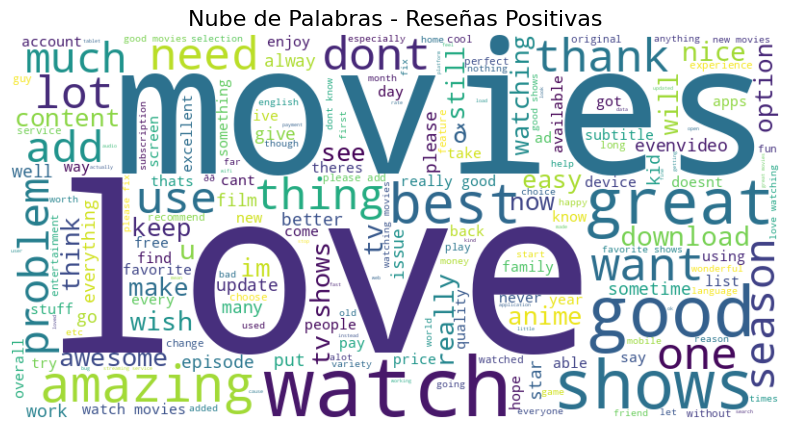

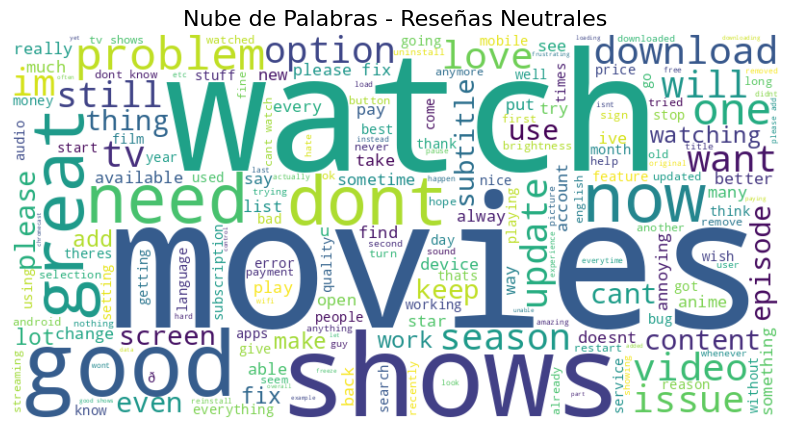

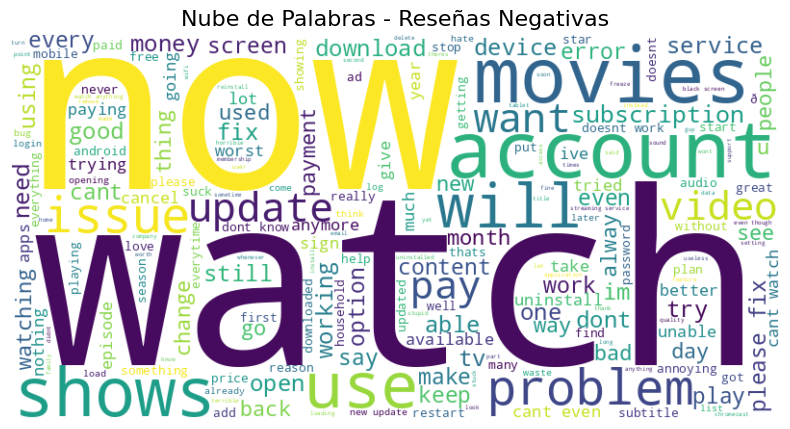

,filtered_content,score,sentiment_label
0,chillarix star is very low for this company it...,1,negative
1,nice,5,positive
2,very nice ð,3,neutral
3,kicked me out of my games from and wont let me...,1,negative
4,how,3,neutral


In [64]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import plotly.graph_objects as go

# Lista de palabras a eliminar
stop_words_custom = {'netflix', 'movie', 'show', 'time', 'app', 'series', 'phone'}

# Paso 1: Mapear los ratings a etiquetas de sentimiento
def map_sentiment(score):
    if score in [4, 5]:
        return 'positive'
    elif score in [1, 2]:
        return 'negative'
    else:
        return 'neutral'

# Asignar etiquetas de sentimiento al DataFrame
df_cleaned['sentiment_label'] = df_cleaned['score'].apply(map_sentiment)

# Paso 2: Filtrar palabras irrelevantes del texto
def clean_text(text):
    words = text.split()
    filtered_words = [word for word in words if word.lower() not in stop_words_custom]
    return ' '.join(filtered_words)

# Aplicar limpieza de texto a la columna 'content_c'
df_cleaned['filtered_content'] = df_cleaned['content_c'].apply(clean_text)

# Paso 3: Generar nubes de palabras para cada categoría
def generate_wordcloud(df, sentiment_label, title):
    # Filtrar texto según el sentimiento y limpiar palabras irrelevantes
    text = " ".join(review for review in df[df['sentiment_label'] == sentiment_label]['filtered_content'])
    wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='viridis').generate(text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title, fontsize=16)
    plt.show()

# Mapeo de los ratings a clasificaciones de sentimiento
def map_sentiment(score):
    if score in [4, 5]:
        return 'Positive'
    elif score in [1, 2]:
        return 'Negative'
    else:
        return 'Neutral'


# Nube de palabras para reseñas positivas
generate_wordcloud(df_cleaned, 'positive', 'Nube de Palabras - Reseñas Positivas')

# Nube de palabras para reseñas neutrales
generate_wordcloud(df_cleaned, 'neutral', 'Nube de Palabras - Reseñas Neutrales')

# Nube de palabras para reseñas negativas
generate_wordcloud(df_cleaned, 'negative', 'Nube de Palabras - Reseñas Negativas')

# Mostrar las primeras filas del DataFrame para ver el contenido filtrado y las etiquetas de sentimiento
df_cleaned[['filtered_content', 'score', 'sentiment_label']].head()



*Reseñas Positivas*

Esta nube de palabras nos ofrece una visión rápida y cualitativa de los términos más frecuentes y relevantes utilizados en las reseñas positivas. Al visualizar las palabras de mayor tamaño, podemos identificar los conceptos y emociones que dominan las opiniones favorables.

Palabras clave y sus implicaciones:

Palabras relacionadas con la experiencia de visualización: "watch", "show", "movie", "series", "episodes", "tv". Estas palabras indican que los usuarios están satisfechos con la plataforma para ver contenido audiovisual.

Emociones positivas: "love", "enjoy", "happy", "good", "great", "amazing". La presencia de estas palabras confirma el sentimiento positivo general de las reseñas.

Características valoradas: "easy", "best", "perfect", "awesome", "quality". Estos términos sugieren que los usuarios aprecian la facilidad de uso, la calidad del contenido y la experiencia general de la plataforma.

Funciones y características: "app", "list", "feature", "download", "content". La mención de estas palabras indica que los usuarios valoran las funcionalidades y el contenido ofrecido por la plataforma.

Comparaciones positivas: "better", "best", "better than". Estas comparaciones implican que los usuarios están satisfechos con la plataforma en comparación con otras opciones.
Conclusiones:

Basándonos en esta nube de palabras, podemos inferir que los usuarios que dejaron reseñas positivas valoran principalmente:

Facilidad de uso: La plataforma es fácil de navegar y utilizar.
Amplia variedad de contenido: Ofrece una gran cantidad de películas, series y otros contenidos audiovisuales.

Alta calidad: El contenido es de buena calidad y cumple con las expectativas de los usuarios.

*Reseñas Neutrales*

A diferencia de la nube de palabras de las reseñas positivas, en esta ocasión encontramos una mezcla de términos positivos y negativos, lo que refleja la naturaleza neutral de las opiniones expresadas. Sin embargo, podemos identificar algunos patrones interesantes:

Problemas técnicos: Abundan palabras como "error", "problem", "bug", "issue", "fix", "doesn't work", "problem". Esto sugiere que muchos usuarios neutrales experimentaron dificultades técnicas al utilizar la plataforma.
Deseos y sugerencias: Palabras como "need", "want", "wish", "should", "add", "improve" indican que los usuarios tienen sugerencias para mejorar la plataforma.
Experiencia mixta: La presencia de palabras como "good", "great", "love" junto con "problem", "annoying" y "bad" refleja una experiencia mixta. Algunos aspectos de la plataforma fueron valorados positivamente, mientras que otros causaron frustración.
Características específicas: Palabras como "subtitle", "audio", "video", "screen", "app" indican que los usuarios se centran en características específicas de la plataforma al expresar sus opiniones.
Conclusiones:

Basándonos en esta nube de palabras, podemos inferir que los usuarios que dejaron reseñas neutrales tienen una opinión ambivalente sobre la plataforma. Por un lado, valoran algunas características y funcionalidades, pero por otro lado, experimentaron problemas técnicos y tienen sugerencias para mejorar la experiencia del usuario

*Reseñas Negativas*

Esta nube de palabras nos ofrece una visión clara de los aspectos negativos que los usuarios perciben en la plataforma. A diferencia de las nubes de palabras de las reseñas positivas y neutrales, aquí predominan términos que expresan frustración, insatisfacción y problemas.

Palabras clave y sus implicaciones:

Problemas técnicos: Abundan palabras como "error", "problem", "bug", "doesn't work", "fix", "issue". Esto indica que muchos usuarios experimentaron problemas técnicos al utilizar la plataforma, lo que afectó significativamente su experiencia.

Dificultades de uso: Palabras como "cant", "unable", "difficult", "try", "trying" sugieren que los usuarios encontraron la plataforma difícil de usar o navegar.

Falta de funcionalidades: Términos como "need", "want", "should", "add" indican que los usuarios desean que se agreguen nuevas funcionalidades o se mejoren las existentes.

Problemas con la cuenta: Palabras como "account", "payment", "subscription", "login" sugieren que los usuarios tuvieron problemas con la gestión de su cuenta o con los pagos.

Contenido: Términos como "show", "movie", "content" junto con palabras negativas como "bad", "worst" indican que los usuarios no están satisfechos con el contenido ofrecido.

*Conclusiones de la nubes:*

Basándonos en esta nube de palabras, podemos inferir que los usuarios que dejaron reseñas negativas experimentaron una serie de problemas al utilizar la plataforma, lo que afectó significativamente su satisfacción. Los principales problemas identificados son:

Problemas técnicos frecuentes: Los usuarios experimentaron una gran cantidad de errores y dificultades técnicas.
Dificultad de uso: La interfaz de usuario no es intuitiva y dificulta la navegación.
Falta de funcionalidades: La plataforma carece de algunas funcionalidades importantes que los usuarios esperan.
Problemas con la gestión de cuentas: Los usuarios experimentaron problemas al crear, gestionar o cancelar sus cuentas.
Contenido insatisfactorio: El contenido ofrecido no cumple con las expectativas de los usuarios.
Comparación con otras nubes de palabras:

Al comparar esta nube de palabras con las de las reseñas positivas y neutrales, podemos observar que en las reseñas negativas predominan los términos negativos y las palabras relacionadas con problemas técnicos y funcionalidades faltantes. En cambio, en las reseñas positivas, predominan los términos relacionados con la satisfacción y la facilidad de uso

Vamos un poco mas alla aplicaremos un modelo **LDA (Latent Dirichlet Allocation)** para ver la relacion entre las palabras esto nos permitira determinar medir la frecuencia con la que las palabras más probables del tema de la aplicacion netflix aparecen juntas en los mismos documentos en todo el corpus.

In [70]:
import gensim
from gensim import corpora
from gensim.models import LdaMulticore
from gensim.corpora import Dictionary
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
!pip install pyLDAvis
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
import pandas as pd
import nltk

# Descargar stopwords de NLTK si no están disponibles
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('punkt_tab')

# Datos de entrada: columna con textos limpios
text_data = df_cleaned['content_c'].dropna().tolist()

# Paso 1: Preprocesar texto
stop_words = set(stopwords.words('english')) | {'netflix', 'movie', 'show', 'time', 'app', 'series', 'phone'}  # Añadir palabras personalizadas
processed_texts = [
    [word for word in word_tokenize(doc.lower()) if word.isalpha() and word not in stop_words]
    for doc in text_data
]

# Paso 2: Crear diccionario y corpus
dictionary = Dictionary(processed_texts)
corpus = [dictionary.doc2bow(text) for text in processed_texts]

# Paso 3: Construir modelo LDA
num_topics = 5  # Número de tópicos
lda_model = LdaMulticore(corpus=corpus, id2word=dictionary, num_topics=num_topics, passes=10, workers=2)

# Paso 4: Imprimir los tópicos
topics = lda_model.print_topics(num_topics=num_topics, num_words=10)
for idx, topic in topics:
    print(f"Topic {idx}: {topic}")

# Paso 5: Visualizar los tópicos
vis = gensimvis.prepare(lda_model, corpus, dictionary)
pyLDAvis.enable_notebook()  # Si estás usando Jupyter Notebook
pyLDAvis.display(vis)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


Topic 0: 0.082*"movies" + 0.046*"good" + 0.045*"shows" + 0.036*"watch" + 0.034*"love" + 0.027*"great" + 0.023*"best" + 0.015*"tv" + 0.015*"like" + 0.014*"amazing"
Topic 1: 0.032*"like" + 0.025*"love" + 0.020*"watch" + 0.020*"dont" + 0.016*"would" + 0.015*"u" + 0.013*"free" + 0.013*"good" + 0.013*"use" + 0.012*"awesome"
Topic 2: 0.026*"cant" + 0.018*"open" + 0.016*"please" + 0.016*"working" + 0.015*"update" + 0.015*"error" + 0.015*"even" + 0.013*"fix" + 0.012*"work" + 0.011*"problem"
Topic 3: 0.016*"money" + 0.014*"account" + 0.014*"subscription" + 0.012*"pay" + 0.011*"service" + 0.011*"cant" + 0.010*"im" + 0.008*"content" + 0.008*"dont" + 0.008*"use"
Topic 4: 0.021*"please" + 0.020*"screen" + 0.019*"video" + 0.017*"watching" + 0.015*"watch" + 0.013*"update" + 0.012*"cant" + 0.010*"episodes" + 0.010*"sometimes" + 0.010*"fix"


El grafico interactivo nos da una idea de los temas principales que emergen de las reseñas.

*Topic 0: Experiencia Positiva General*

Este tópico parece capturar la experiencia positiva general de los usuarios.

Palabras clave como "movies", "shows", "love", "good", "great", "best", "amazing" indican que este tópico está asociado con la satisfacción con el contenido, la plataforma y la experiencia de visualización.

*Topic 1: Problemas Técnicos y de Uso*

Este tópico parece estar relacionado con problemas técnicos y dificultades de uso.

Palabras como "cant", "dont", "use", "unable" sugieren frustración.
La presencia de "free" podría indicar problemas con la versión gratuita o con la prueba gratuita.

*Topic 2: Problemas de Actualización y Funcionalidad*

Este tópico parece centrarse en problemas relacionados con actualizaciones, errores y funcionalidades de la plataforma.
Palabras como "update", "error", "working", "fix", "cant", "even" respaldan esta interpretación.

Topic 3: Problemas de Pago y Suscripción

Este tópico parece estar relacionado con problemas de pago, suscripción y cuenta.
Palabras como "money", "account", "subscription", "pay", "service" indican que este tópico aborda temas financieros y de gestión de cuenta.

*Topic 4: Problemas de Visualización y Reproducción*

Este tópico parece centrarse en problemas relacionados con la visualización y reproducción de contenido.

Palabras como "screen", "video", "watching", "play", "cant", "fix" sugieren problemas con la calidad de la imagen, la reproducción de videos, etc.
Interpretación General:

Estos resultados del LDA sugieren que los principales temas de preocupación para los usuarios son:

Experiencia positiva general: Un grupo significativo de usuarios está satisfecho con la plataforma y su contenido.

Problemas técnicos y de uso: Los usuarios experimentan dificultades técnicas y de uso que afectan su experiencia.

Problemas con pagos y suscripciones: Existen problemas relacionados con la gestión de cuentas y los pagos.

Problemas de visualización y reproducción: Los usuarios enfrentan dificultades al reproducir contenido o experimentan problemas con la calidad de la imagen

In [2]:
import pandas as pd

# Crear un DataFrame de ejemplo
data = {'content_c': [
    "This is the first review",
    "Another review about Netflix series",
    "The movie was not great",
    "I love the new Netflix show",
    "Worst experience ever with this app"
]}
df_cleaned = pd.DataFrame(data)


In [6]:
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd

# Stop words personalizadas
custom_stop_words = {'netflix', 'movie', 'show', 'time', 'app', 'series', 'phone'}

# Crear el TfidfVectorizer con límite de características
vectorizer = TfidfVectorizer(
    ngram_range=(2, 2),  # Bigramas
    stop_words=list(custom_stop_words),  # Convert set to list here
    max_features=1000  # Limitar a los 1000 bigramas más frecuentes
)

# Transformar el texto limpio en bigramas
X = vectorizer.fit_transform(df_cleaned['content_c'].dropna())  # Usamos la columna 'content_c' limpia

# Extraer los bigramas y sus frecuencias
n_grams = vectorizer.get_feature_names_out()
frequencies = X.toarray().sum(axis=0)

# Crear un DataFrame para almacenar bigramas y frecuencias
df_n_grams = pd.DataFrame({
    'n_gram': n_grams,
    'frecuencia': frequencies
}).sort_values(by='frecuencia', ascending=False).reset_index(drop=True)

# Mostrar los 10 bigramas más frecuentes
print(df_n_grams.head(10))


            n_gram  frecuencia
0   another review    0.707107
1         love the    0.707107
2     review about    0.707107
3          the new    0.707107
4        not great    0.577350
5          the was    0.577350
6          was not    0.577350
7        ever with    0.500000
8  experience ever    0.500000
9     first review    0.500000


Los resultados muestran los bigramas más frecuentes en las reseñas. Algunos ejemplos son: "another review", "love the", "review about", "the new", "not great". Estos bigramas pueden revelar patrones y temas recurrentes en las reseñas, como expresiones de opinión, descripciones de la experiencia de visualización o críticas comunes.